In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import MetaTrader5 as mt5
from account_credentials import LOGIN,PASSWORD,SERVER
from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [4]:
is_initialized = mt5.initialize()
print('initialize: ', is_initialized)

is_logged_in = mt5.login(LOGIN, PASSWORD, SERVER)
print('logged in: ', is_logged_in)
print('\n')
account_info = mt5.account_info()
print(datetime.now(),
    '| Login: ', account_info.login,
    '| Balance: ', account_info.balance,
    '| Equity: ' , account_info.equity)

initialize:  True
logged in:  True


2023-04-24 07:13:02.194412 | Login:  114123121 | Balance:  484.96 | Equity:  484.96


In [5]:
symbol = 'XAUUSD'
number_of_date= 10000
timeframe = mt5.TIMEFRAME_H1
from_date = datetime.now()

df = pd.DataFrame(mt5.copy_rates_from(symbol,timeframe,from_date,number_of_date))
df["time"] = pd.to_datetime(df["time"], unit="s")
df = df.rename(columns={'time': 'date','tick_volume':'volume'})
df = df[['date','open','high','low','close','volume']]
df = df.set_index("date")
print(df.head()) # just to make sure that sorted from old to new

                         open      high       low     close  volume
date                                                               
2021-08-12 09:00:00  1755.788  1756.388  1753.587  1753.790    2980
2021-08-12 10:00:00  1753.793  1753.846  1750.953  1751.065    3226
2021-08-12 11:00:00  1751.049  1752.592  1749.401  1749.506    3859
2021-08-12 12:00:00  1749.475  1751.626  1743.801  1749.394    9928
2021-08-12 13:00:00  1749.360  1750.339  1741.435  1747.612   10858


##### Adding Features

In [6]:
df['RSI'] = ta.rsi(df.close, length = 15)
df['EMAF'] = ta.ema(df.close, length = 20)
df['EMAM'] = ta.ema(df.close, length = 100)
df['EMAS'] = ta.ema(df.close, length = 150)
# df['Target'] = df['close'] - df.open
# df['Target'] = df['Target'].shift(-1)

# df['TargetClass'] = [1 if df.Target[i] > 0 else 0 for i in range(len(df))]
df['Target-Next-Close'] = df['close'].shift(-1)



df.dropna(inplace = True)
df.reset_index(inplace = True)
df.drop(['date','volume'], axis=1 , inplace=True)
# df = df[0:100]
df

,open,high,low,close,RSI,EMAF,EMAM,EMAS,Target-Next-Close
0,1782.712,1783.168,1782.049,1782.390,47.334745,1783.298374,1780.637229,1778.417160,1781.291
1,1782.457,1782.457,1780.318,1781.291,44.789380,1783.107195,1780.650175,1778.455224,1778.198
2,1781.435,1782.340,1778.167,1778.198,38.540119,1782.639653,1780.601617,1778.451817,1778.682
3,1778.201,1779.197,1777.385,1778.682,39.944974,1782.262734,1780.563605,1778.454866,1779.190
4,1778.669,1779.747,1777.201,1779.190,41.450015,1781.970092,1780.536405,1778.464603,1785.581
...,...,...,...,...,...,...,...,...,...
9845,1980.631,1982.496,1978.914,1979.144,37.030215,1986.999096,1997.340980,1999.535108,1982.674
9846,1979.113,1983.001,1978.653,1982.674,42.080794,1986.587182,1997.050545,1999.311782,1982.924
9847,1982.707,1983.615,1981.768,1982.924,42.431162,1986.238308,1996.770811,1999.094725,1984.011
9848,1982.119,1984.011,1981.826,1984.011,44.009038,1986.026183,1996.518142,1998.894941,1984.657


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler_x = StandardScaler().fit(df.iloc[:,:8])
scaled_x = scaler_x.transform(df.iloc[:,:8])
scaler_y = StandardScaler().fit(df.iloc[:,8].values.reshape(-1, 1))
scaled_y = scaler_y.transform(df.iloc[:,8].values.reshape(-1, 1))
scaled_x.shape

In [7]:
scaler_x = MinMaxScaler(feature_range=(0,1))
scaled_x = scaler_x.fit_transform(df.iloc[:,:8])
print(scaled_x.shape)
scaled_x

(9850, 8)


array([[0.36665467, 0.36180411, 0.38337061, ..., 0.38082037, 0.37089088,
        0.36490158],
       [0.36609156, 0.36022417, 0.37940753, ..., 0.38035812, 0.37092484,
        0.36500425],
       [0.36383471, 0.35996418, 0.37448286, ..., 0.37922766, 0.37079746,
        0.36499506],
       ...,
       [0.8082978 , 0.80722506, 0.84062265, ..., 0.87150498, 0.93785822,
        0.96013655],
       [0.80699934, 0.80810503, 0.84075544, ..., 0.87099209, 0.93719541,
        0.95959767],
       [0.81121272, 0.81114936, 0.8455061 , ..., 0.8706768 , 0.93657928,
        0.95908901]])

In [8]:
scaler_y = MinMaxScaler(feature_range=(0,1))
scaled_y = scaler_y.fit_transform(df.iloc[:,8].values.reshape(-1, 1))
print(scaled_y.shape)
scaled_y

(9850, 1)


array([[0.36353036],
       [0.35669959],
       [0.35776848],
       ...,
       [0.81122958],
       [0.81265625],
       [0.81036828]])

In [9]:
# # Save the array to a CSV file
# np.savetxt('arrayx.csv', scaled_x, delimiter=',')
# np.savetxt('arrayy.csv', scaled_y, delimiter=',')

In [10]:
X = []
backcandles = 30
print(scaled_x.shape[0])
for j in range(8): 
    X.append([])
    for i in range(0, scaled_x.shape[0]-backcandles+1):
        X[j].append(scaled_x[i:i+backcandles, j])
print(np.array(X).shape)

X = np.moveaxis(X, [0], [2])  # move the feature axis to the second dimension
print(X.shape)

9850
(8, 9821, 30)
(9821, 30, 8)


In [11]:
# X = []
# backcandles = 30
# print(df_a.shape[0])
# for j in range(8): # grabe open	high	low	close	RSI	EMAF	EMAM	EMAS
#     X.append([])
#     for i in range(backcandles, df_a.shape[0]):
#         X[j].append(df_a[i-backcandles:i, j])
# X=np.moveaxis(X, [0], [2])
# X.shape


# X = []
# backcandles = 30
# print(scaled_x.shape[0])
# for j in range(8): 
#     X.append([])
#     for i in range(backcandles, scaled_x.shape[0]):
#         X[j].append(scaled_x[i-backcandles:i, j])
# X = np.moveaxis(X, [0], [2])  # move the feature axis to the second dimension
# X = X[::-1]  # reverse the order of the samples to put the most recent data at the end
# X.shape


In [12]:
X[0,0,:]

array([0.36665467, 0.36180411, 0.38337061, 0.36595746, 0.44301708,
       0.38082037, 0.37089088, 0.36490158])

In [13]:
X[0,1,:]

array([0.36609156, 0.36022417, 0.37940753, 0.36353036, 0.41193648,
       0.38035812, 0.37092484, 0.36500425])

In [24]:
# X = X
y = scaled_y[(scaled_y.shape[0]-X.shape[0]):,:] # matching the shape of X
# y = np.reshape(y,(len(y),1))
print(X.shape) # 3D X has 8 colume and each colume contain xx backcandles (row, backcandle, column)
print(y.shape) # 2D contain 1 value (it's 1D array that reshape into 2D array)
print(y)

(9821, 30, 8)
(9821, 1)
[[0.40734402]
 [0.40916379]
 [0.4124809 ]
 ...
 [0.81122958]
 [0.81265625]
 [0.81036828]]


In [25]:
proportion = int(len(X)*0.8)
X_train, X_test = X[:proportion],X[proportion:]
y_train, y_test = y[:proportion],y[proportion:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X[1,1:10,1])

(7856, 30, 8)
(7856, 1)
(1965, 30, 8)
(1965, 1)
[0.35996418 0.35298    0.35420217 0.36870385 0.37244371 0.37403476
 0.37345034 0.37287702 0.37008824]


In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the Sequential model
model = Sequential()

# Add the LSTM layer with 150 units and input shape (backcandles, 8)
model.add(LSTM(units=150, input_shape=(backcandles, 8), name='lstm_layer'))

# Add a dense layer with a single output neuron and linear activation function
model.add(Dense(units=1, activation='linear', name='output'))

# Compile the model with the Adam optimizer and mean squared error loss function
model.compile(optimizer='adam', loss='mse')

# Train the model on the training data with a batch size of 15 and for 30 epochs
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_data=(X_test, y_test))


Epoch 1/30
524/524 [==============================] - 5s 8ms/step - loss: 0.0014 - val_loss: 2.9838e-04
Epoch 2/30
524/524 [==============================] - 4s 8ms/step - loss: 1.1671e-04 - val_loss: 1.8579e-04
Epoch 3/30
524/524 [==============================] - 4s 8ms/step - loss: 1.0816e-04 - val_loss: 1.0865e-04
Epoch 4/30
524/524 [==============================] - 4s 8ms/step - loss: 1.0406e-04 - val_loss: 9.6190e-05
Epoch 5/30
524/524 [==============================] - 4s 7ms/step - loss: 1.0068e-04 - val_loss: 8.8937e-05
Epoch 6/30
524/524 [==============================] - 4s 7ms/step - loss: 9.7435e-05 - val_loss: 2.7059e-04
Epoch 7/30
524/524 [==============================] - 4s 7ms/step - loss: 9.0400e-05 - val_loss: 8.1619e-05
Epoch 8/30
524/524 [==============================] - 4s 7ms/step - loss: 9.9498e-05 - val_loss: 2.1758e-04
Epoch 9/30
524/524 [==============================] - 4s 8ms/step - loss: 8.4363e-05 - val_loss: 1.2515e-04
Epoch 10/30
524/524 [===========

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_layer (LSTM)           (None, 150)               95400     
                                                                 
 output (Dense)              (None, 1)                 151       
                                                                 
Total params: 95,551
Trainable params: 95,551
Non-trainable params: 0
_________________________________________________________________


In [28]:
y_hat = model.predict(X_test)
for i in range(10):
    print(y_hat[i], y_test[i])

62/62 [==============================] - 0s 4ms/step
[0.3935506] [0.41190007]
[0.41441128] [0.4208355]
[0.4218288] [0.41936909]
[0.4205012] [0.42188894]
[0.42358422] [0.40652689]
[0.4056374] [0.41728209]
[0.41621822] [0.43233496]
[0.4307554] [0.43859816]
[0.44123676] [0.44466922]
[0.4431939] [0.44453892]


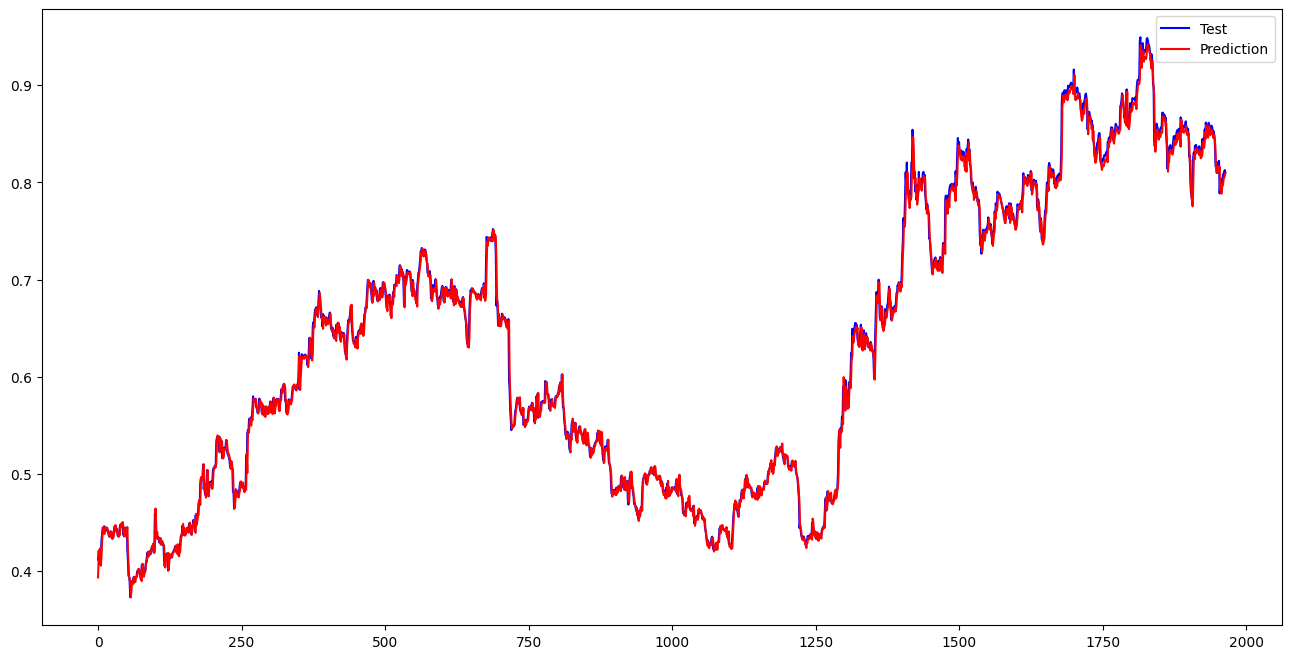

In [29]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_hat, color = 'red', label = 'Prediction')
plt.legend()
plt.show()

In [30]:
y_hat_inverse = scaler_y.inverse_transform(y_hat)
print(y_hat_inverse)
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))
print(y_test_inverse)

[[1794.8843]
 [1804.3301]
 [1807.6887]
 ...
 [1981.0764]
 [1981.938 ]
 [1983.1257]]
[[1803.193]
 [1807.239]
 [1806.575]
 ...
 [1984.011]
 [1984.657]
 [1983.621]]


In [42]:
#อันนี้ถ้าได้ค่าเป็นบวก ก็แค่บอกเป็นความในว่า ใน data ที่ใช้ test นี้ ส่วนไหญ่แล้วมี Tredn ราคาหลักไปทางนั้งมากกว่า เช่น ถ้าเป็น positve แปลว่าส่วนมาก ราคาขึ้น negative ก็แปลว่าส่วนมากราคาลง
diff = []
for i in range(0,len(y_hat_inverse)):
    val = float(y_hat_inverse[i] - y_test_inverse[i])
    diff.append(val)
pred_diff = sum(diff)/len(diff)
print(f"pred_diff {pred_diff}")



#อาจจะเป็น predict long or short ก็ได้ regardless of neg or pos, see below
# Predict < ClosePrice(from predict) > actual ---> Short ---> P - a = Positive Value
# Predict < ClosePrice(from predict) < actual ---> Short ---> P - a = Negative Value
# Predict > ClosePrice(from predict) > actual ---> Long ---> P - a = Positive Value
# Predict > ClosePrice(from predict) < actual ---> Long ---> P - a = Negative Value
# ด้วยเหตุผลนี้ ใช้ เป็น abs น่าจะ make sense มากกว่าในการทำ simulation
diff_pos = []
diff_neg = []
v_zero = []
for i in range(0,len(y_hat_inverse)):
    val = float(y_hat_inverse[i] - y_test_inverse[i])
    if val > 0:
        diff_pos.append(val)
    elif val < 0:
        diff_neg.append(val)
    elif val ==0:
        v_zero.append(val)
    else:
        raise ValueError("All conditions were not met")
pred_diff_pos = sum(diff_pos)/len(diff_pos)
pred_diff_neg = sum(diff_neg)/len(diff_neg)
print(f"pred_diff_pos {pred_diff_pos}")
print(f"pred_diff_neg {pred_diff_neg}")
print(f"v_zero {v_zero}")

#ใช้อันนี้น่าจะ make sense สุดเพราะ เราไม่สามารถรู้ได้ว่ามันจะ เป็น Negative Diff หรือว่า Positive Diff, regardless what's the type of trading order is.
diff = []
for i in range(0,len(y_hat_inverse)):
    val = abs(float(y_hat_inverse[i] - y_test_inverse[i]))
    diff.append(val)
pred_diff_abs = sum(diff)/len(diff)
print(f"pred_diff_abs {pred_diff_abs}")

pred_diff_abs 2.7070048798306288
pred_diff -0.8873293659549973
pred_diff_pos 2.3617320903339594
pred_diff_neg -2.923372016957266
v_zero []


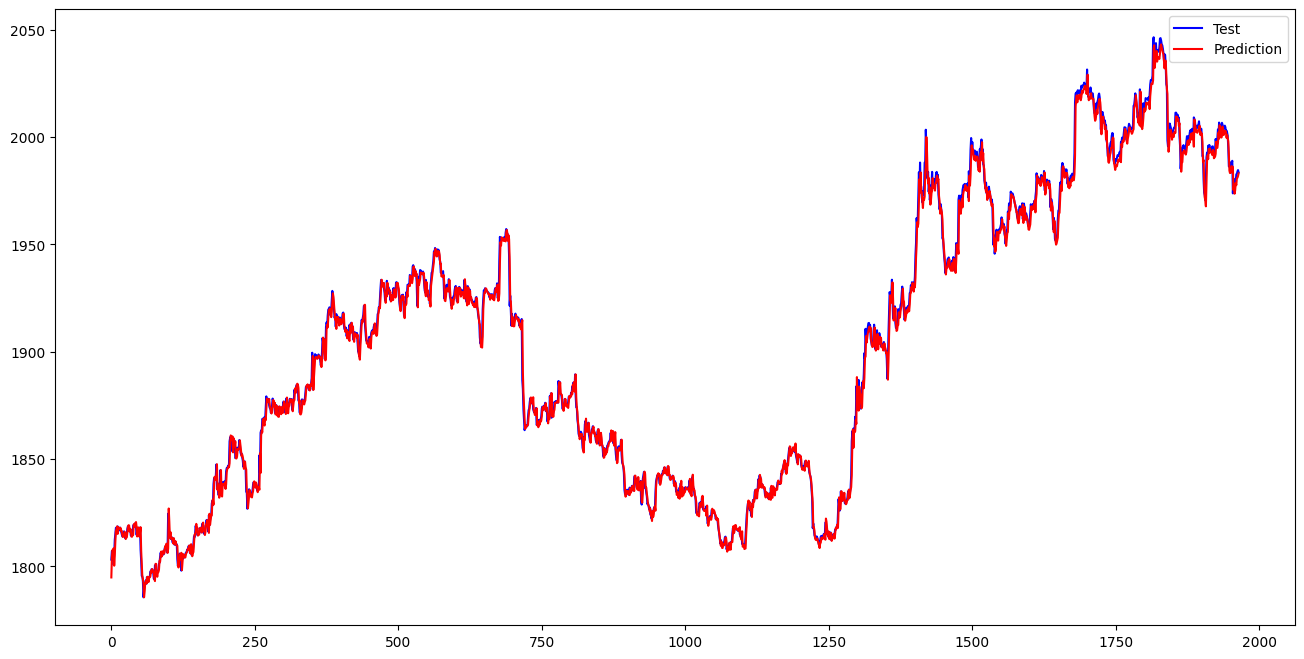

In [32]:
plt.figure(figsize=(16,8))
plt.plot(y_test_inverse, color = 'blue', label = 'Test')
plt.plot(y_hat_inverse, color = 'red', label = 'Prediction')
plt.legend()
plt.show()

In [38]:
# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test)

# Print the mean squared error loss
print('Test loss:', loss)

# Generate predictions on the test data
y_pred = model.predict(X_test)

# Compute the mean squared error (MSE) and root mean squared error (RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Compute the coefficient of determination (R-squared)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print("TEST SET")
print('Mean squared error (MAE)(loss):', mae)
print('Mean squared error (MSE)(loss):', mse)
print('Root mean squared error (RMSE):', rmse)
print('R-squared (R2):', r2)
print()

loss = model.evaluate(X_train, y_train)
print('Training loss:', loss)

y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_train, y_pred)
print("TRAINING SET")
print('Mean squared error (MAE)(loss):', mae)
print('Mean squared error (MSE):', mse)
print('Root mean squared error (RMSE):', rmse)
print('R-squared (R2):', r2)

62/62 [==============================] - 0s 4ms/step - loss: 7.5160e-05
Test loss: 7.515983452321962e-05
62/62 [==============================] - 0s 4ms/step
TEST SET
Mean squared error (MAE)(loss): 0.005978307467842737
Mean squared error (MSE)(loss): 7.515979965126845e-05
Root mean squared error (RMSE): 0.008669475165848763
R-squared (R2): 0.9966375953864083

246/246 [==============================] - 1s 4ms/step - loss: 5.8793e-05
Training loss: 5.879315358470194e-05
246/246 [==============================] - 1s 4ms/step
TRAINING SET
Mean squared error (MAE)(loss): 0.005105129265053993
Mean squared error (MSE): 5.879319839694799e-05
Root mean squared error (RMSE): 0.007667672293267885
R-squared (R2): 0.9981643931719654


In [39]:
if prediction >= 0
    (prediction-pred_diff)

SyntaxError: invalid syntax (2083105578.py, line 1)

In [ ]:
if prediction - close > 3 then buy
if target > 3 then buy is correct
This is correct
else false

if prediction - close < 3 then sell
if target > 3 then sell is correct
This is correct
else false

if prediction - close > 3 AND prediction - close < 3 then doing nothing

# with a single model it cannot predict sell and buy at the sametime

In [ ]:
# float(model.predict(X_test[0, :, :].reshape(1, 30, 8)))
# y_hat = model.predict(X_test)
# float(y_hat[0])
scaled_sample_x = scaler_x.inverse_transform(X_train[0, :, :])
scaled_sample_x[0,4]
# y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
def predict_simu(model, X_test, data_simu_y, initial_capital):
    capital = initial_capital
    win_count = 0
    lost_count = 0
    no_order_count = 0
    record_result = []
    record_capital = []
    record_date = []
    consecutive_lost = 0
    consecutive_lost_max = 0
    for i in range(0, len(X_test)):
        prediction = float(model.predict(X_test[0, :, :].reshape(1, 30, 8)))
        
        if prediction == 1 and data_simu_y[i] == 1:
            outcome = 3
            capital += outcome
            win_count += 1
            order_record = 'win-------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'win'
        elif prediction == 1 and data_simu_y[i] == 0:
            outcome = -3.3
            capital += outcome
            lost_count += 1
            order_record = 'lost------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'lost'
        elif prediction == 0:
            no_order_count +=1
            order_record = 'no order--- prediction = {0}, actual = {1}'.format(prediction, data_simu_y[i])
            capital = capital
            result = 'no order'
        else:
            raise ValueError('no condition met')
        record_date.append(X_test.iloc[i].name)
        record_result.append(order_record)
        record_capital.append(capital)

        #Calculate Consecutive Lost
        if result == 'lost':
            consecutive_lost += -3.3
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
        if result == 'win':
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
            consecutive_lost = 0

    total_return = ((capital - initial_capital) / initial_capital)*100
    sim_df = pd.DataFrame({'record_date':record_date,
                           'record_result':record_result,
                           'record_capital': record_capital})
    sim_df.set_index('record_date', inplace=True)

    return win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max
